# Assignment 1 - Track 6
### Luca Miglior

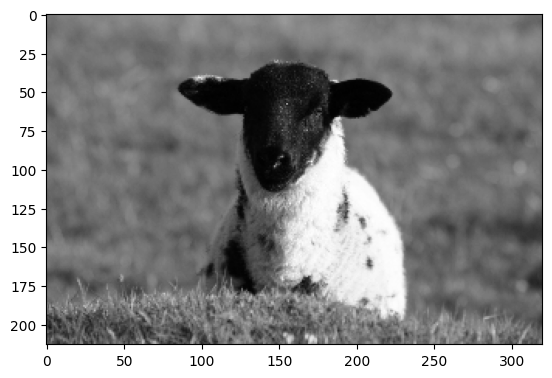

In [32]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import cv2


img = cv2.imread('./images/1_27_s.bmp', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.show()

### Defining convolution function and LoG generator

Log defined as:
$$ \nabla^2G(x,y) = -\frac{1}{\pi\sigma^4} \left[1 - \frac{x^2+y^2}{2\sigma^2}\right] \exp \left\{ -\frac{x^2+y^2}{2\sigma^2}\right\} $$

Convolution function defined as:
$$ C(x,y) = \sum_{i=0}^{k} \sum_{j=0}^{k} I(x+i,y+j)K(i,j) $$
where $I$ is the image, $K$ is the kernel and $k = dim(K)$

Image has been padded with zeros to avoid boundary issues. Moreover, numba JIT was used to improve computation time of for loops.

In [2]:
def convolve(img, kernel) -> np.ndarray:

    h, w = img.shape
    kh, kw = kernel.shape
    conv = np.zeros((h, w))

    # some padding
    img = np.pad(img, (kh//2, kw//2), 'constant')

    # separate function for numba
    @numba.jit(nopython=True)
    def process(img, h, w, kh, kw, conv):
        # iterate over image
        for x in range(h):
            for y in range(w):
                # of course using compact numpy notation instead of explicit loops for sum
                conv[x, y] = (kernel * img[x: x+kh, y: y+kw]).sum()
        return conv

    return process(img, h, w, kh, kw, conv)

@numba.jit(nopython=True)
def log(i, j, sigma):
    return (-1)/(np.pi * sigma**4) * (1 - (i**2 + j**2)/(2*sigma**2)) * np.exp(-(i**2+j**2)/(2*sigma**2))

@numba.jit(nopython=True)
def laplacian_of_gaussian(dim, sigma=1, k=1):
    kernel = np.zeros((dim, dim)) 
    for i in range(-dim//2, dim//2+1):
        for j in range(-dim//2, dim//2+1):
            kernel[i+dim//2, j+dim//2] = log(i, j, sigma)

    # normalize kernel
    return sigma**2 * kernel

## First try: test kernel generation and convolution implementation

### Kernel plot

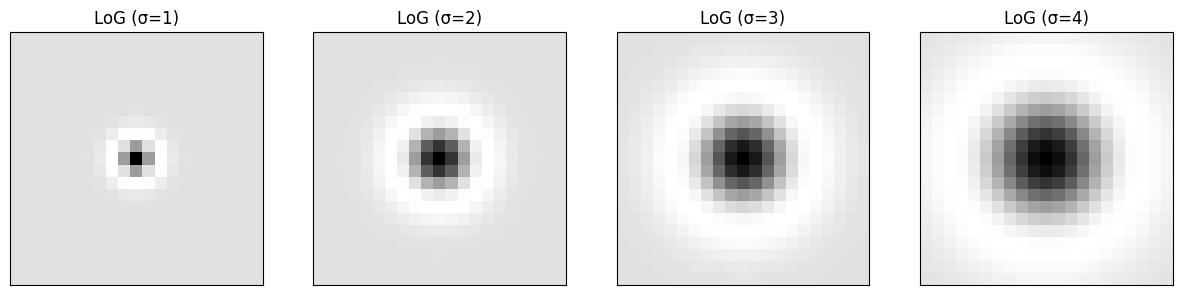

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, sigma in enumerate([1, 2, 3, 4]):
    kernel = laplacian_of_gaussian(21, sigma)
    axs[i].imshow(kernel, cmap='gray')
    axs[i].set_title(f'LoG (σ={sigma})')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Generated kernels actually are LoGs. This pictures also suggest how in the next part larger kernels will be needed to exploit higher sigma values and to provide a good local LoG approximation.

 Now, test convolution on the normalized image, with sigma = 2 and kernel size = 21

### Convolution test

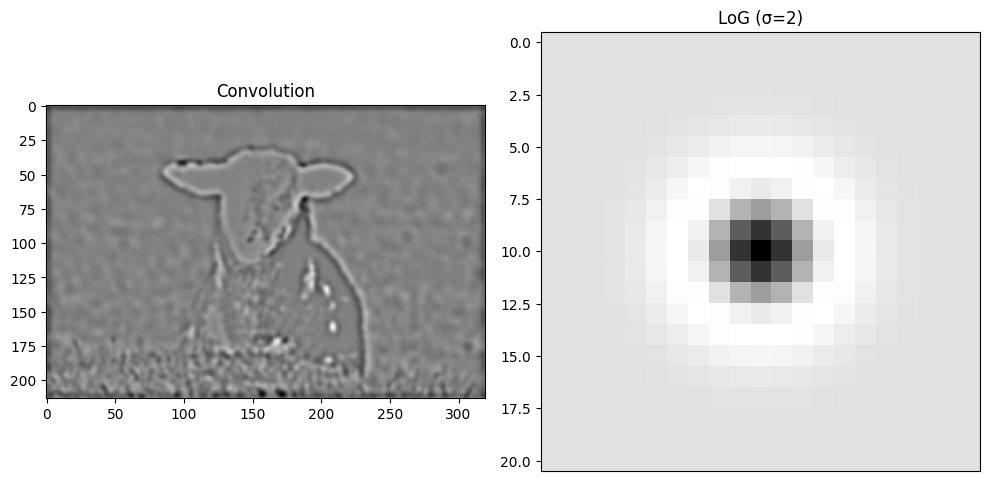

In [4]:
kernel = laplacian_of_gaussian(21, 2)
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# normalizing image to [0, 1]
axs[0].imshow(convolve(img/255, kernel), cmap='gray')

axs[0].set_title('Convolution')
axs[1].imshow(kernel, cmap='gray')
axs[1].set_title('LoG (σ=2)')
axs[1].set_xticks([])
fig.tight_layout()

It works as expected, since LoG is basically an edge detector.

### Comparison of my convolution with openCV.filter2D. 
 Note: openCV.filter2D actually computes correlation, not convolution.

Text(0.5, 1.0, 'OpenCV')

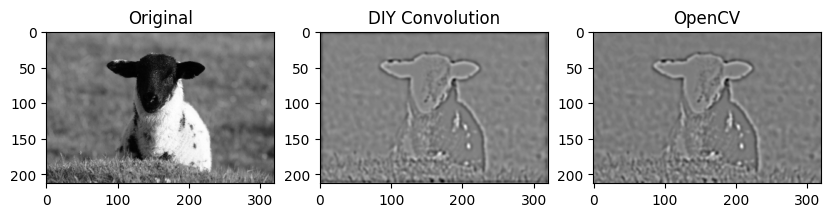

In [5]:
filtered = convolve(img/255, kernel)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img/255, cmap='gray')
axs[1].imshow(filtered, cmap='gray')
axs[2].imshow(cv2.filter2D(img/255, -1, kernel), cmap='gray')

axs[0].set_title('Original')
axs[1].set_title('DIY Convolution')
axs[2].set_title('OpenCV')

### Now, let's see what happens changing sigma scale.

I will test sigma from 1 to 3, with 0.1 step.
Kernel size will be 21 as usual. I found this to be a good tradeoff between accuracy and computation time.

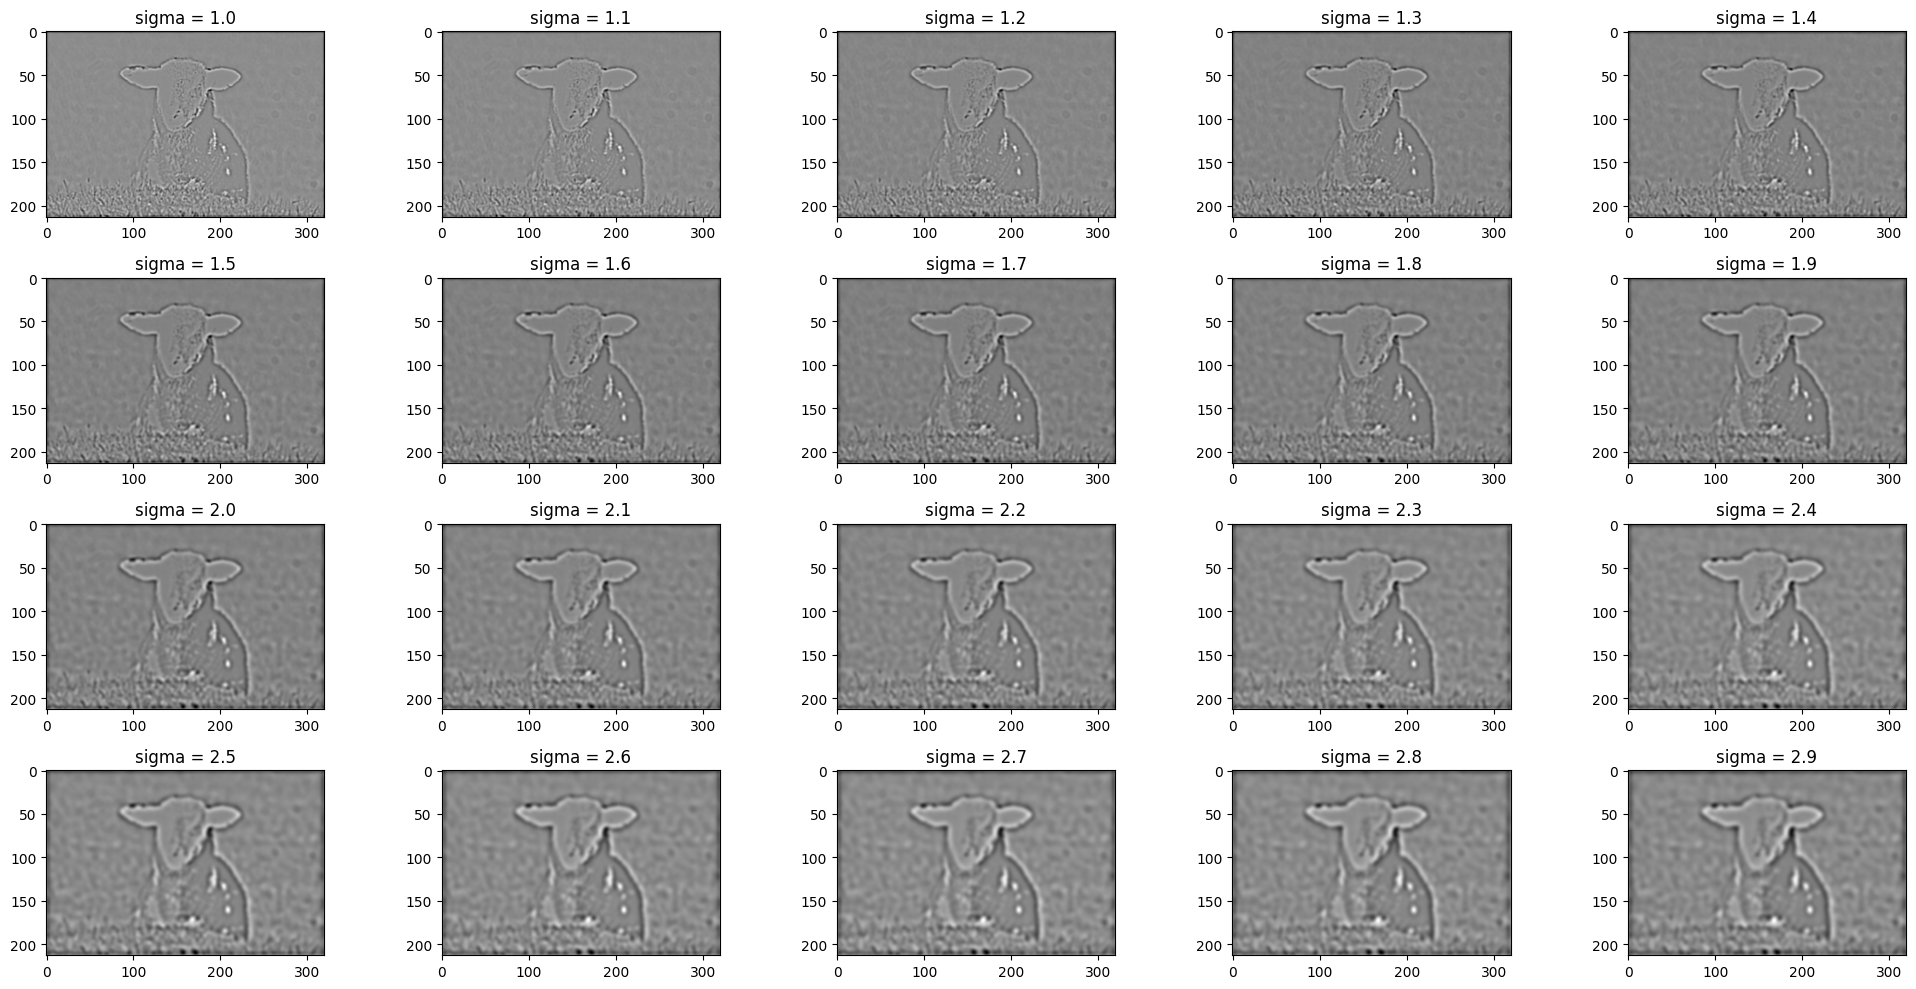

In [6]:
# try 10 values of sigma and plot it in range 1.5 to 2.5 with step 0.1
sigmas = np.arange(1, 3, 0.1)

fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i, sigma in enumerate(sigmas):
    kernel = laplacian_of_gaussian(21, sigma)
    filtered = convolve(img/255, kernel)
    axs[i//5, i%5].imshow(filtered, cmap='gray')
    axs[i//5, i%5].set_title(f'sigma = {round(sigma,2)}')
fig.tight_layout()

### Results:
Sigma scaling seem working as expected. The more sigma increases, the more the image becomes blurred.

## Let's dig into the tricky part: blob detection

In order to detect blobs, we have to convolve the image with the LoG kernel at different scales. Since blobs are areas of gradient stability, we have to find the local maxima of the LoG response, across different scales. We also have to threshold the response, to avoid everything to be considered a blob. Moreover, we have to remove duplicates, since the same pixel may be considered a blob center in different iterations of the algorithm. 

The algorithm was built on the top of the papers cited in the last section. 
The main steps are:

> - Generate a set of kernels, with different sigma values, within a user selected range (bounded by `sigma_start` and `sigma_end`). User may also want to change kernel dimension.
> - For each kernel, convolve the image with it. Now we have a 3D matrix, of shape `(image_height, image_width, len(kernels))`.
> - Generate also an array `blob_cords` to store the coordinates of the blobs found and the corresponding sigma value.
> - Now, the algorithm will iterate across this 3D matrix, pixel by pixel, considering a surrounding 2D window of size `stride`. Now, we find the maximum of this new 3D matrix of shape (stride, stride, len(kernels)). If this maximum is greater than the threshold, we consider the pixel as a blob center.
> - After this, we store blob center coordinates, and the corresponding sigma value, in `blob_cords`. The sigma value will be multiplied by $\sqrt2$ since LoGs have maximum response within a circle of radius $\sigma\sqrt2$.


Users may also want to change stride value, normalize image flip the kernel sign and use the absolute value of the filter response.


In [7]:
def detect_blobs(img, threshold=1, sigma_start=1, sigma_end=4, sigma_step=1, kernel_size=11, stride=3, normalize=False, abs=False, negative_kernel=False):

    if normalize:
        img = img/np.max(img)

    scales = np.arange(sigma_start, sigma_end, sigma_step)
    kernels = [laplacian_of_gaussian(kernel_size, s) for s in scales]

    if negative_kernel:
        kernels = [-k for k in kernels]

    height, width = img.shape

    filtered = [convolve(img, kernel) for kernel in kernels]
    filtered = np.array([np.pad(i, (stride, stride), 'constant') for i in filtered])
    blob_cords = []
   
    for x in range(1, height, stride):
        for y in range(1, width, stride):
            if abs:
                region = np.abs(filtered[:, x:x+stride, y:y+stride])
            else:
                region = filtered[:, x:x+stride, y:y+stride]
            candidate_max = np.max(region)
            level, h, w = np.unravel_index(np.argmax(region), region.shape)
            if candidate_max > threshold:
                blob_cords.append((1.414*(scales[level]), x+h-stride, y+w-stride))

    # this will return unique triples 
    return set(blob_cords)

## Test the algorithm

Let's first test the algorithm on our sheep image. The following cell will show results for different threshold values.
Images have been normalized to [0,1] range. Kernel size and stride are 71 and 10 respectively. Sigma range is 2 to 20, with 1.0 stepsize.
This values were empirically found again as a good tradeoff between accuracy and computation time. In general, as sigma increases, we will need to increase kernel size, because of the accuracy of the approximation of the LoG. Increasing sigma and kernel size tipically improved blob's quality across different scales.

Blobs were plotted by exploiting Circle funtion built in in Matplotlib

**Warining**: next cells may take a while to run.

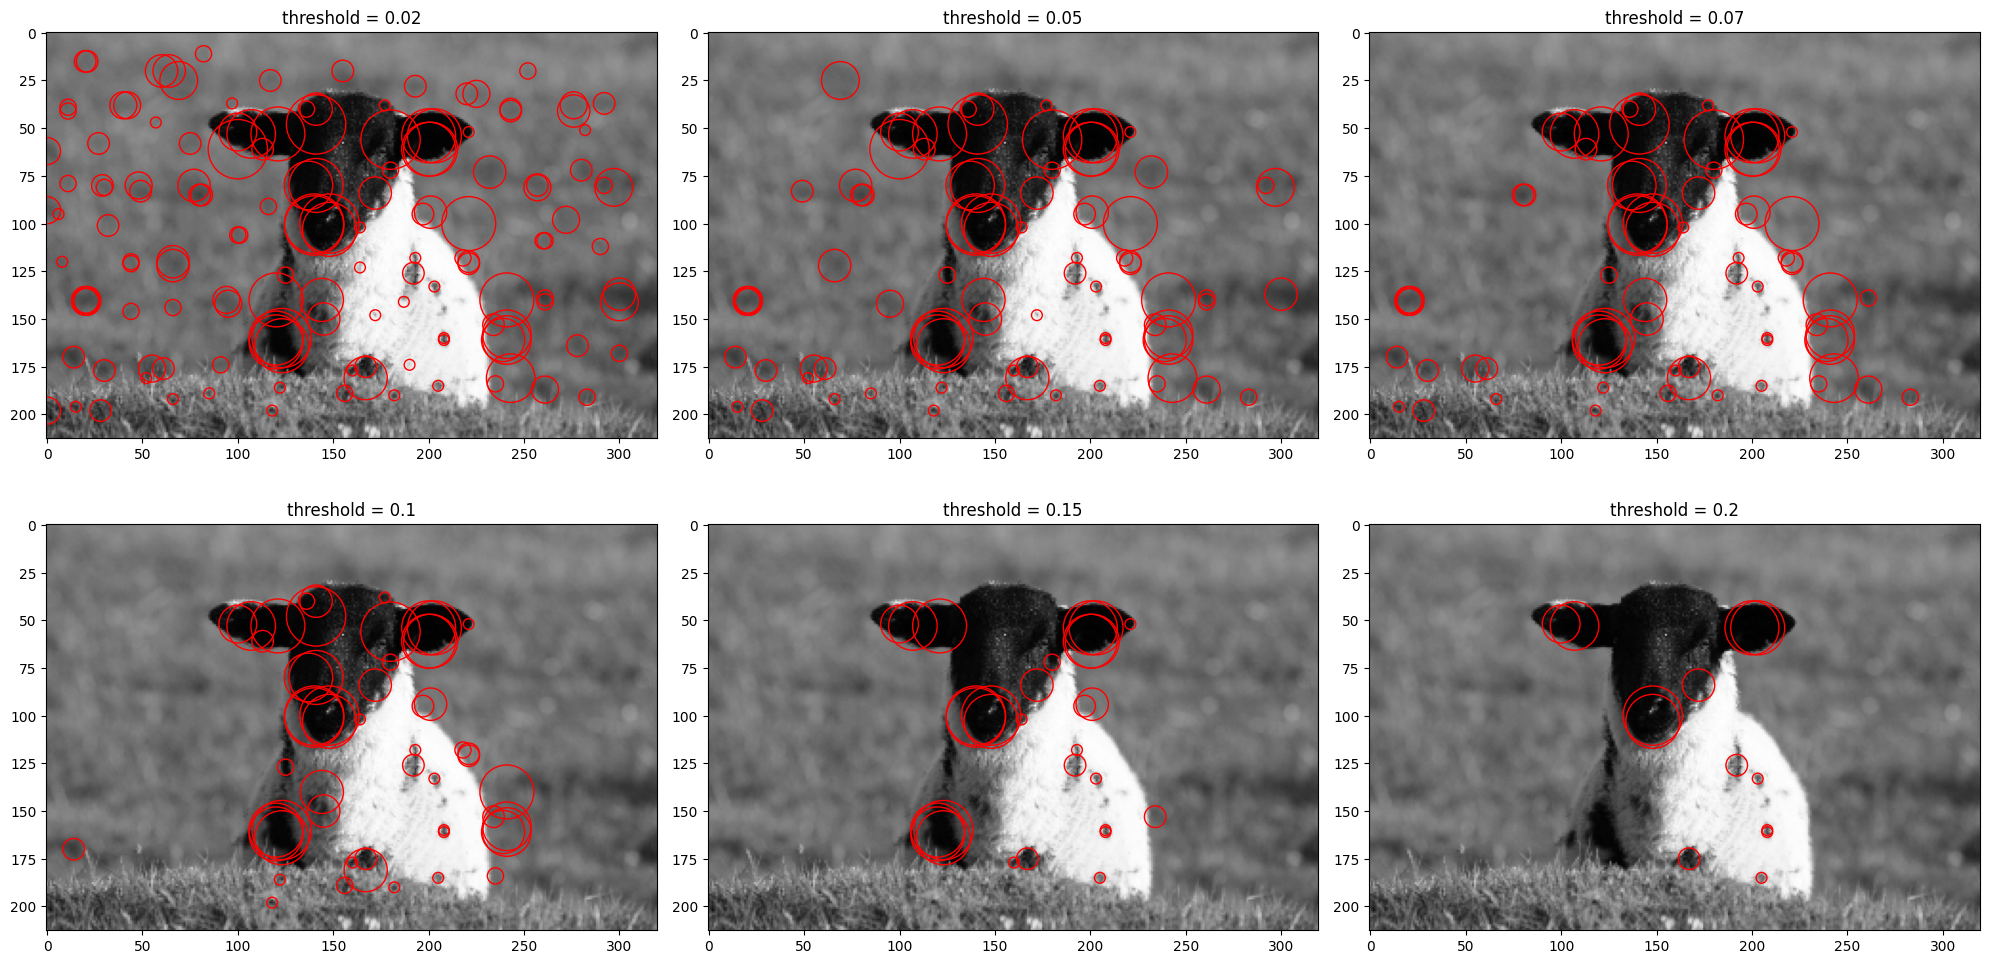

In [72]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# try different values of threshold
for i, threshold in enumerate([0.02, 0.05, 0.07, 0.1, 0.15, 0.2]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=2, 
        sigma_end=20, 
        sigma_step=1, 
        kernel_size=71, 
        stride=20, 
        normalize=True,
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))


fig.tight_layout()

Note: for this image i found that picking only "dark" blobs helped to detect actual blobs. Probably due to the fact that this image present high contrast areas which may be alter the threshold sensitivity of the algorithm  (i.e. smaller dark blobs inside light areas may need a lower threshold to be detected). It is eventually possible to run again the algorithm on the same image, then merging the results of dark blob detection and light blob detections.

In [ ]:
dark_blobs = detect_blobs(
    img, 
    threshold=0.16, 
    sigma_start=2, 
    sigma_end=20, 
    sigma_step=1, 
    kernel_size=71, 
    stride=20, 
    normalize=True,
)

light_blobs = detect_blobs(
    img,
    threshold=0.16,
    sigma_start=2,
    sigma_end=6,
    sigma_step=1,
    kernel_size=31,
    stride=10,
    normalize=True,
    negative_kernel=True,
)

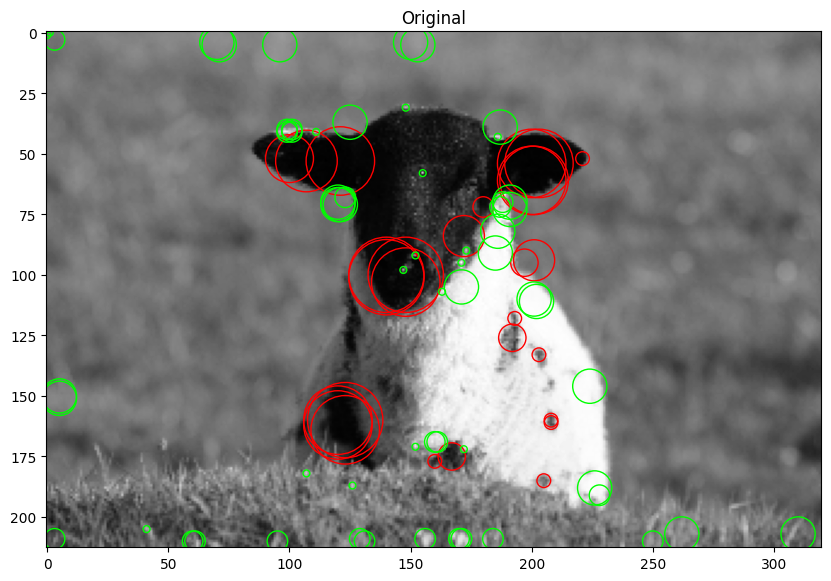

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.imshow(img, cmap='gray')
axs.set_title('Light and Dark Blobs')

for blob in dark_blobs:
    axs.add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))
for blob in light_blobs:
    axs.add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='lime'))

### Trying on different subjects: humans

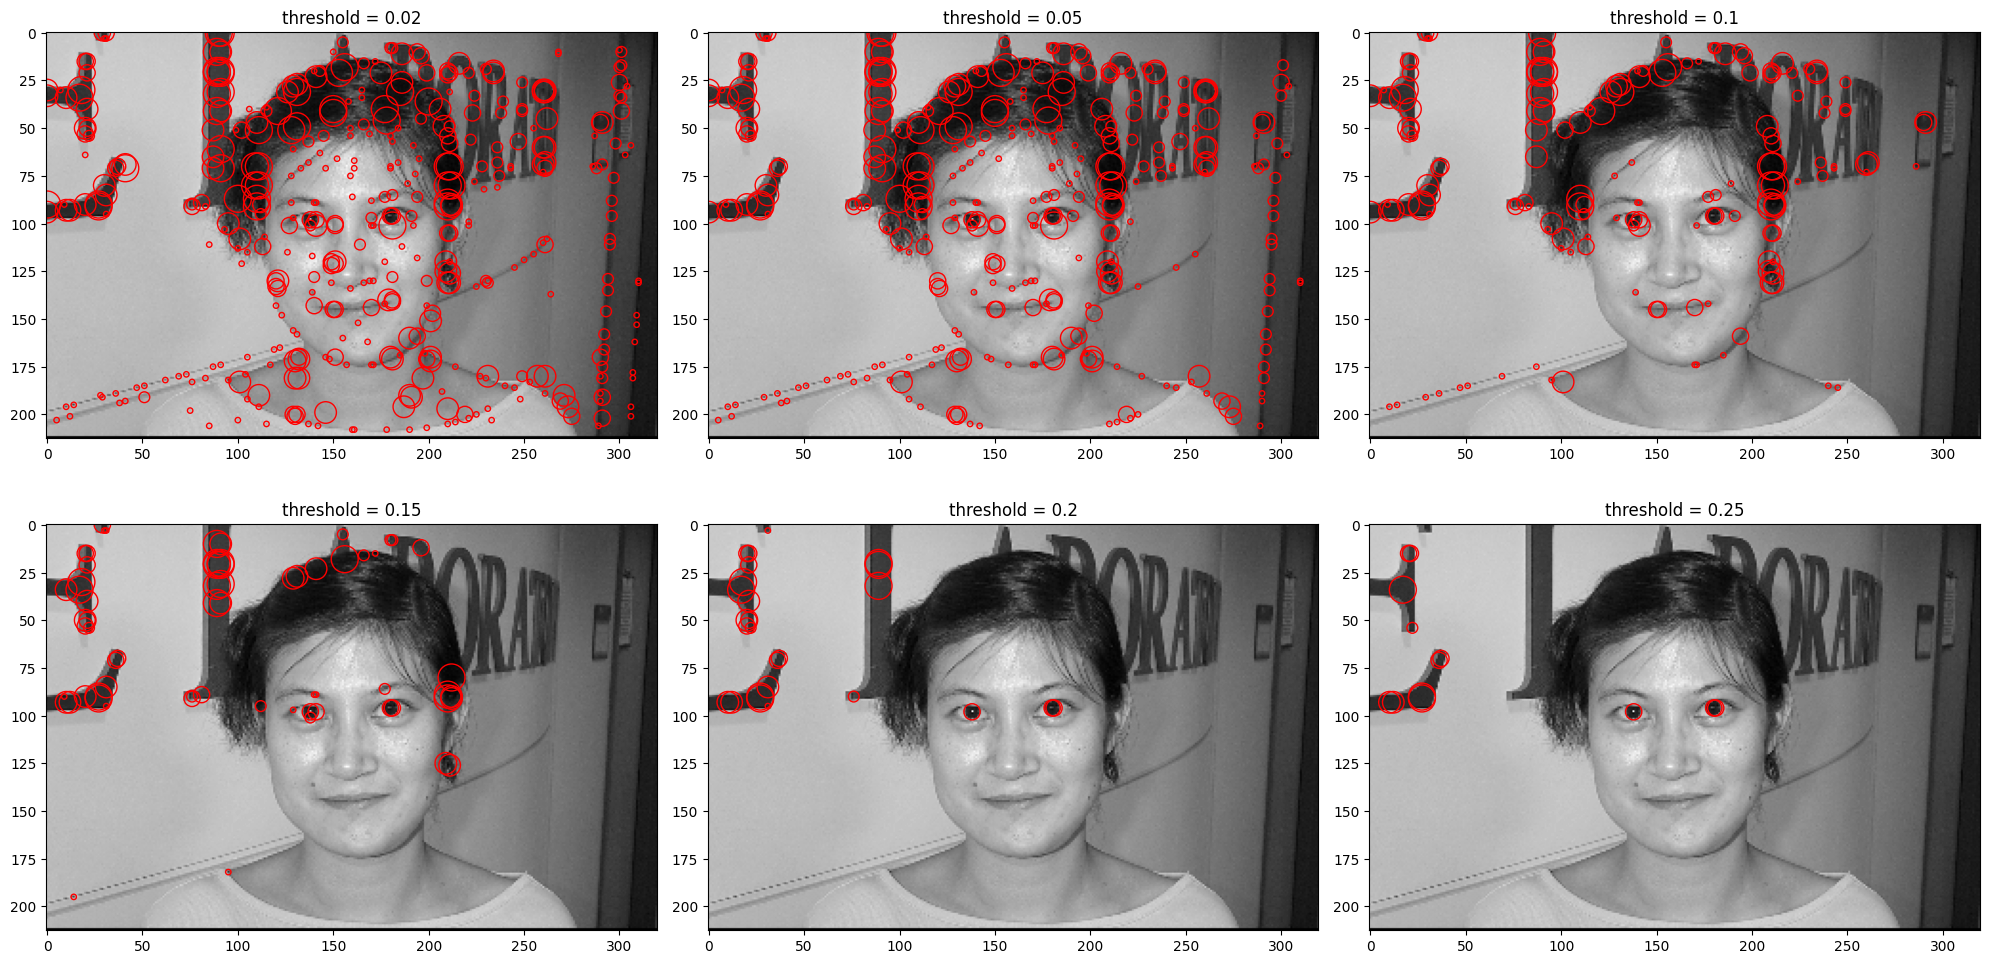

In [26]:
# test on human face image
img = cv2.imread('./images/6_30_s.bmp', cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, threshold in enumerate([0.02 ,0.05, 0.1, 0.15, 0.2, 0.25]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=1, 
        sigma_end=6, 
        sigma_step=1, 
        kernel_size=31, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))


fig.tight_layout()


### Blob detection works also on humans.
In particular, it seems to be able to detect perfectly detect eyes (even with high threshold values on the normalized image) and mouth borders. In the above pictures also small moles on the skin and face were detected by the function, with the correct blob size. 
Note: the algorithm did not detected blobs when taking the absolute value of the convolutionm probably due to the high luminance areas around the nose and the forehead (same issue of the previous image).

### Test on buildings

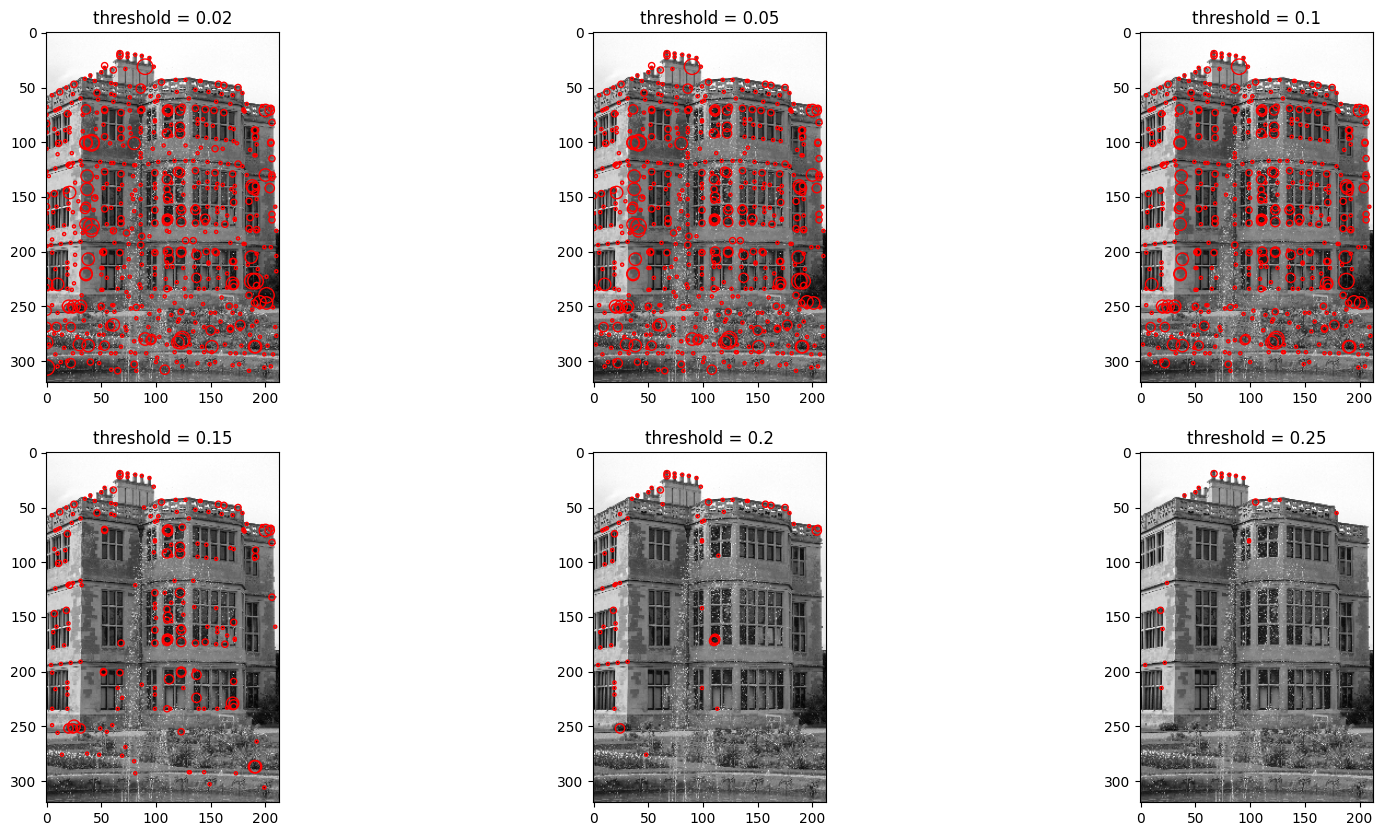

In [28]:
img  = cv2.imread('./images/3_2_s.bmp', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, threshold in enumerate([0.02 ,0.05, 0.1, 0.15, 0.2, 0.25]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=1, 
        sigma_end=6, 
        sigma_step=1, 
        kernel_size=31, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))


This image was chosen because of the precence of many windows and some noise due to the presence of a fountain in the foreground.

### Test on cars

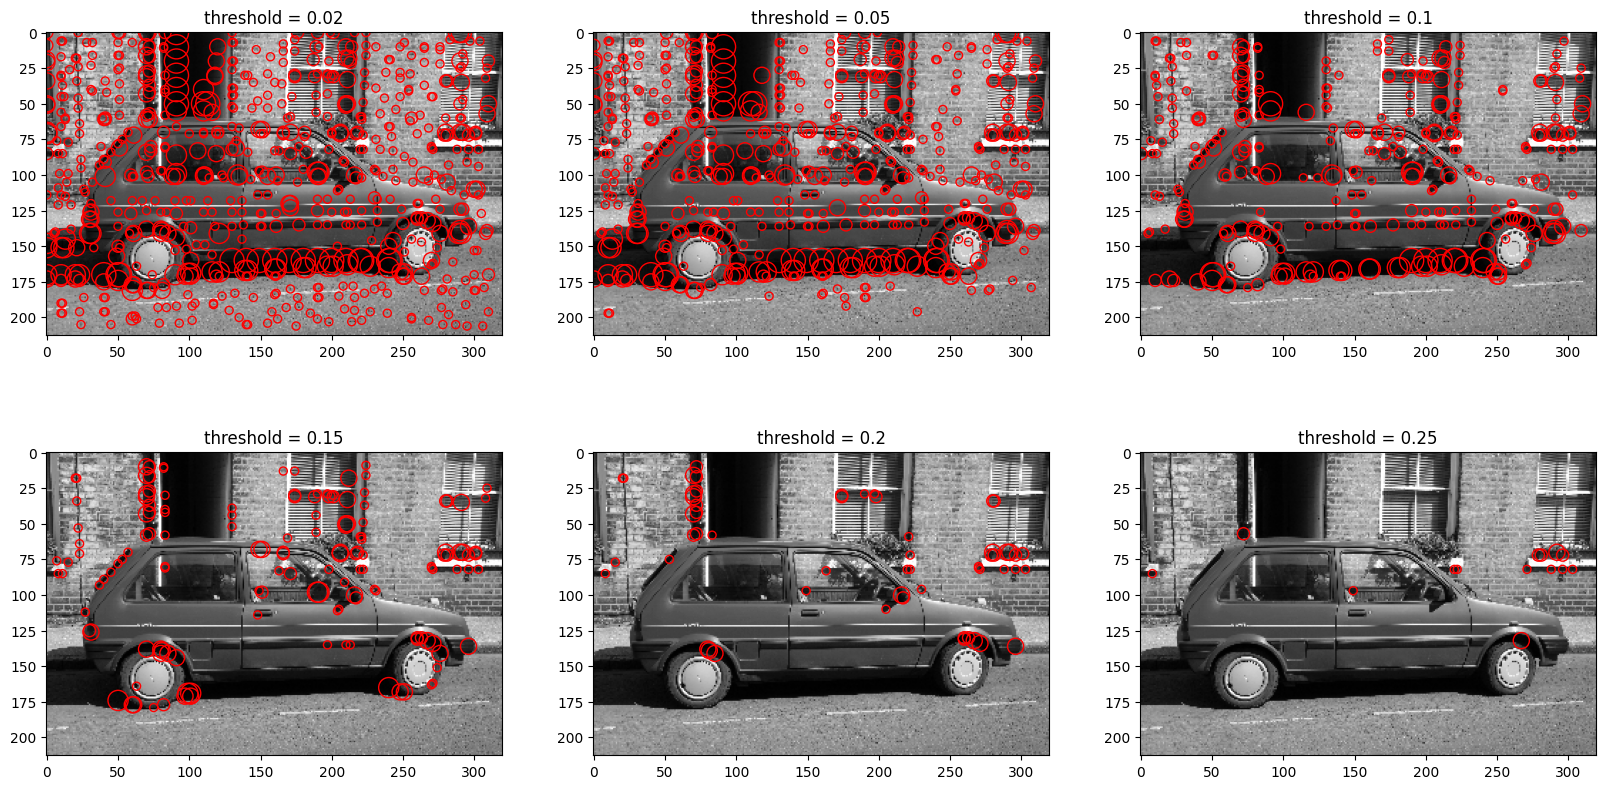

In [31]:
img = cv2.imread('./images/7_6_s.bmp', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, threshold in enumerate([0.02 ,0.05, 0.1, 0.15, 0.2, 0.25]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=2, 
        sigma_end=10, 
        sigma_step=1, 
        kernel_size=31, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))

#### Since wheels are light, let's try to take the absolute value of th LoG response and see if we can detect them

In fact, our previous kernel was made to detect dark blobs out of images, with high contrast background. The previous effect clearly shows how our kernel will keep identifying borders as maximum LoG stability, preferring tires instead of a whole wheel. With the abs value, we should be able to detect the whole wheel.

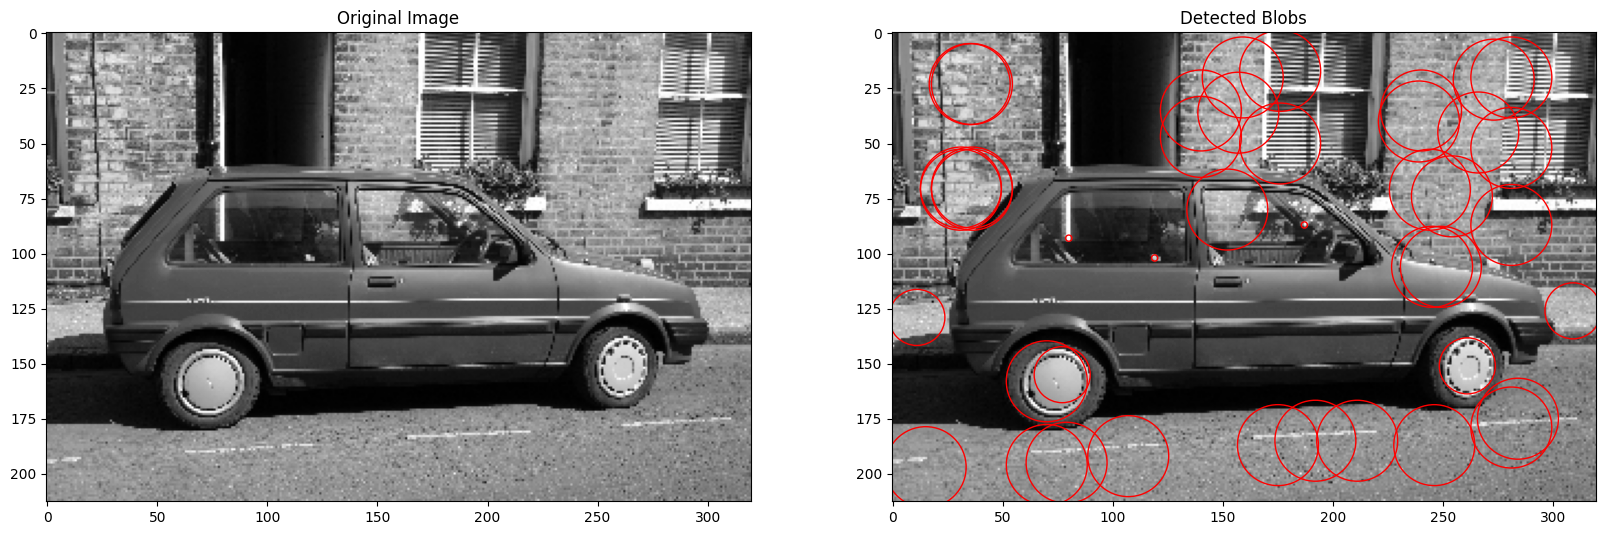

In [81]:
img = cv2.imread('./images/7_6_s.bmp', cv2.IMREAD_GRAYSCALE)

blobs = detect_blobs(
        img, 
        threshold=0.35, 
        sigma_start=1, 
        sigma_end=20, 
        sigma_step=4, 
        kernel_size=31, 
        stride=35, 
        normalize=True,
        abs=True # added this
 ) 

# plot blobs
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].set_title('Detected Blobs')

for blob in blobs:
    axs[1].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))
axs[1].imshow(img, cmap='gray')


Now wheels are clearly detected by the algorithm as a blob. Since the background is light, the detector will keep detecting blobs on it.
Parameters were chosen after some little trial and errors to avoid noisy results. Note how the taking the absolute value of the LoG response helped to detect both light and dark blobs simultanously

## Conclusions and future work

In conclusion, the proposed algorithm was able to detect blobs in different images, across different subjects. In general, images with low contrast resulted in slightly lower performances in blob detection, probably due to the fact that we use LoG kernels. Performance drastically improved by increasing kernel size, probably thanks to the finer approximation of the function. In particular, it was mandatory to use big kernels with high sigma values, in order to detect increasingly bigger blobs. (e.g. 31x31 kernel with sigma up to 20 in order to detect $20\sqrt{2}$ radius blobs). In fact, small kernels with large sigmas provided a nearly black (uniform) kernel, leading to very low response in general. 

Moreover, this algorithm works only for greyscale images. For future work, it would be nice to extend the algorithm also to RGB images, by applying algorithm to each channel, then finding an algorithm to merge results. 

Another limitation of this implementation may be the capability of recognizing only circular shaped blobs. As proposed in [2] this blob detector may be modified to produce elliptical kernels, then detecting blobs with elliptical shape with different eccentricities. It would also be useful to remove overlapping blobs, or maybe use them to define blobs with arbitrary shapes.

Finally, the algorithm may be optimized to run in parallel architectures, by slicing images and matrices in differend parts The algorithm may be optimized by using a GPU, exploiting CUDA or OpenCL.

## References
The proposed algotithm is based on the following papers and materials:

1. Course slides
2. [H. Kong et al. A Generalized Laplacian of Gaussian Filter for Blob Detection and Its Applications](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6408211)
3. [G. Wang et al. Automated blob detection using iterative Laplacian of Gaussian filtering and unilateral second-order Gaussian kernels](https://www.sciencedirect.com/science/article/abs/pii/S1051200419301460?casa_token=ICir1eATqakAAAAA:oYIkoxYUneQLjjmJ9fGDx4oCKuY77bED0cYuTZBH7ptyNbqSfhzMYFkRJh6m1aJPUGE3ziIi)

4. [D. G. Lowe. Distinctive Image Features from Scale-Invariant Keypoints](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94)
